In [67]:
import pandas_datareader as pdr
import datetime
import pandas as pd

# Define the start and end dates for the data
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

# Fetch 10-year constant maturity Treasury rates
cmt_data_10y = pdr.get_data_fred("GS10", start_date, end_date, freq='M')
cmt_data_10y['time to maturity'] = range(1, len(cmt_data_10y) + 1)





# Display the data
print(cmt_data_10y)


            GS10  time to maturity
DATE                              
2020-01-01  1.76                 1
2020-02-01  1.50                 2
2020-03-01  0.87                 3
2020-04-01  0.66                 4
2020-05-01  0.67                 5
2020-06-01  0.73                 6
2020-07-01  0.62                 7
2020-08-01  0.65                 8
2020-09-01  0.68                 9
2020-10-01  0.79                10
2020-11-01  0.87                11
2020-12-01  0.93                12
2021-01-01  1.08                13
2021-02-01  1.26                14
2021-03-01  1.61                15
2021-04-01  1.64                16
2021-05-01  1.62                17
2021-06-01  1.52                18
2021-07-01  1.32                19
2021-08-01  1.28                20
2021-09-01  1.37                21
2021-10-01  1.58                22
2021-11-01  1.56                23
2021-12-01  1.47                24
2022-01-01  1.76                25
2022-02-01  1.93                26
2022-03-01  2.13    

In [68]:
len(cmt_data_10y)

46

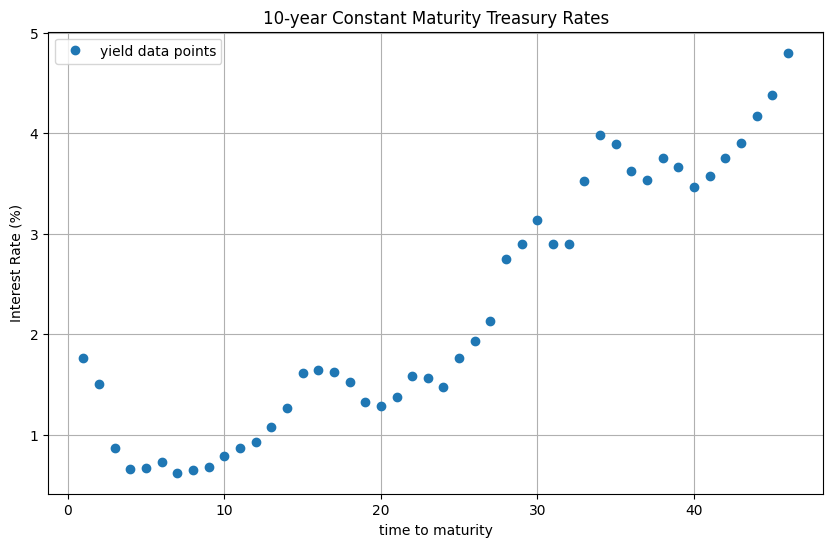

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
#plt.scatter(cmt_data_10y.index, cmt_data_10y['GS10'], label='10-year CMT', color='blue', marker='o')
plt.title('10-year Constant Maturity Treasury Rates')
plt.xlabel('time to maturity')
plt.ylabel('Interest Rate (%)')
plt.plot(cmt_data_10y['time to maturity'], cmt_data_10y['GS10'], 'o', label = 'yield data points')
plt.legend()
plt.grid(True)
plt.show()

### Cubic spline

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta
from scipy.interpolate import CubicSpline
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

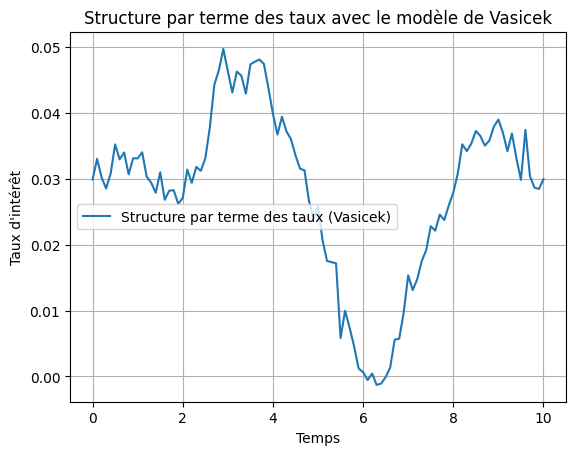

In [5]:
r0=0.03
k=0.1
theta=0.05
sigma=0.01
T=10
# num_points = len(df.index) + 1
num_points= 100
dt = T / num_points
time_points = np.linspace(0, T, num_points + 1)
    
    # Calcul de la structure par terme des taux avec le modèle de Vasicek
rates = theta + (r0 - theta) * np.exp(-k * time_points) + sigma * np.sqrt(dt) * np.random.normal(size=num_points + 1).cumsum()

    # Tracé de la courbe
# plt.figure(figsize=(10, 6))
plt.plot(time_points, rates, label='Structure par terme des taux (Vasicek)')
plt.title('Structure par terme des taux avec le modèle de Vasicek')
plt.xlabel('Temps')
plt.ylabel('Taux d\'intérêt')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
cs = CubicSpline(cmt_data_10y['time to maturity'], cmt_data_10y['GS10'])
curve_points = np.linspace(min(cmt_data_10y['time to maturity']), max(cmt_data_10y['time to maturity']), 1000)

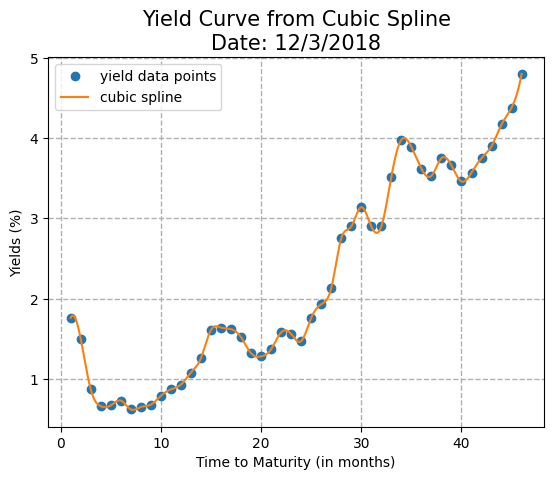

In [72]:
plt.figure()
plt.title('Yield Curve from Cubic Spline\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(cmt_data_10y['time to maturity'], cmt_data_10y['GS10'], 'o', label = 'yield data points')
plt.plot(curve_points, cs(curve_points), label="cubic spline")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

# nelson

In [73]:
lamda = 0.0605
b0 = 1
b1 = 1
b2 = 1
beta = [b0, b1, b2]

In [74]:

def NS_yield(time_, beta_):
    level_factor =  1
    slope_factor = (1 - np.exp((-1)*lamda*time_))/(lamda*time_)
    curvature_factor = (1 - np.exp((-1)*lamda*time_))/(lamda*time_) - np.exp((-1)*lamda*time_)
    return (beta_[0]*level_factor + beta_[1]*slope_factor + beta_[2]*curvature_factor)

In [75]:
def factor_loading(time_):
    level_factor_loading = []
    slope_factor_loading = []
    curvature_factor_loading = []
    for i in time_:
        level_factor_loading.append(1)
        slope_factor_loading.append((1 - np.exp((-1)*lamda*i))/(lamda*i))
        curvature_factor_loading.append((1 - np.exp((-1)*lamda*i))/(lamda*i) - np.exp((-1)*lamda*i))
    
    return level_factor_loading, slope_factor_loading, curvature_factor_loading

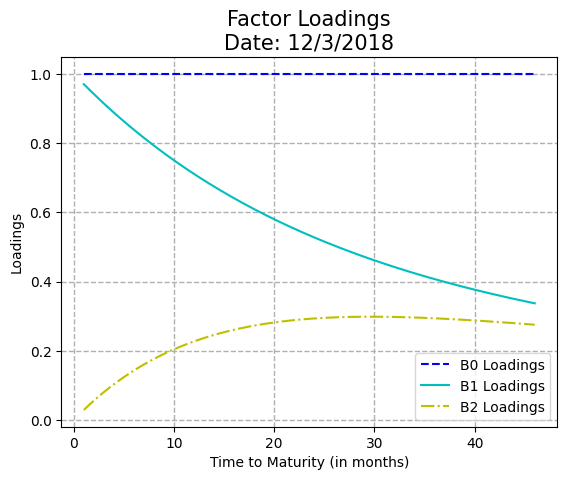

In [76]:
b0_loading, b1_loading, b2_loading = factor_loading(curve_points)

plt.figure()
plt.title('Factor Loadings\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Loadings')
plt.plot(curve_points, b0_loading, '--', color = 'b', label = 'B0 Loadings')
plt.plot(curve_points, b1_loading, '-', color = 'c', label="B1 Loadings")
plt.plot(curve_points, b2_loading, '-.', color = 'y', label="B2 Loadings")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

In [77]:
def residual(beta_, time_array, yields_):
    errors = []
    c_index = 0
    for i in yields_:
        errors.append(NS_yield(time_array[c_index], beta_) - i)
        c_index += 1
    return np.array(errors)

In [78]:
residual(beta, cmt_data_10y['time to maturity'], cmt_data_10y['GS10'])


C:\Users\maria\AppData\Local\Temp\ipykernel_17388\1811275206.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  errors.append(NS_yield(time_array[c_index], beta_) - i)


array([ 0.23940808,  0.49770225,  1.12498181,  1.33133905,  1.31685969,
        1.2516233 ,  1.35570372,  1.31916943,  1.28208392,  1.16450598,
        1.07649007,  1.00808655,  0.84934201,  0.66029948,  0.30099869,
        0.2614763 ,  0.27176608,  0.36189914,  0.55190409,  0.58180722,
        0.48163266,  0.26140254,  0.27113709,  0.35085483,  0.05057266,
       -0.12969405, -0.3399313 , -0.97012639, -1.13026783, -1.38034525,
       -1.15034929, -1.16027157, -1.79010459, -2.25984168, -2.17947691,
       -1.91900507, -1.83842158, -2.06772249, -1.98690436, -1.79596428,
       -1.9148998 , -2.10370892, -2.26239001, -2.5409418 , -2.75936337,
       -3.18765409])

In [79]:
from scipy.optimize import least_squares
res = least_squares(residual, beta, args = (cmt_data_10y['time to maturity'], cmt_data_10y['GS10'] ))
optimum_beta = res.x
print('beta values: ', optimum_beta)
print('cost: ', res.cost)

beta values:  [ 13.29542452 -11.88109783 -17.17707632]
cost:  2.2760019991829465


C:\Users\maria\AppData\Local\Temp\ipykernel_17388\1811275206.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  errors.append(NS_yield(time_array[c_index], beta_) - i)


In [80]:
residual(optimum_beta, cmt_data_10y['time to maturity'], cmt_data_10y['GS10'])

C:\Users\maria\AppData\Local\Temp\ipykernel_17388\1811275206.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  errors.append(NS_yield(time_array[c_index], beta_) - i)


array([-4.92526742e-01, -3.54069882e-01,  1.77718562e-01,  3.10993469e-01,
        2.44034786e-01,  1.45239527e-01,  2.33114274e-01,  1.96268143e-01,
        1.73406189e-01,  8.33232169e-02,  3.48979893e-02,  1.70877860e-02,
       -8.10766909e-02, -2.00496094e-01, -4.82006907e-01, -4.36385642e-01,
       -3.34352771e-01, -1.46576409e-01,  1.46324231e-01,  2.83775608e-01,
        2.95246819e-01,  1.90246766e-01,  3.18321495e-01,  5.19051712e-01,
        3.42050447e-01,  2.86960878e-01,  2.03454288e-01, -2.98771851e-01,
       -3.29995657e-01, -4.50472523e-01, -9.04366737e-02,  2.98973649e-02,
       -4.69666603e-01, -8.09307724e-01, -5.99189295e-01, -2.09459881e-01,
       -2.54362573e-04, -1.01694917e-01,  1.06108074e-01,  4.23055162e-01,
        4.29057043e-01,  3.64033805e-01,  3.27914239e-01,  1.70635185e-01,
        7.21409298e-02, -2.37617360e-01])

In [81]:
import statsmodels.api as sm

beta_sm = [1, 1, 1]
level_factor_sm =  np.ones(cmt_data_10y['time to maturity'].size)
slope_factor_sm = (1 - np.exp((-1)*lamda*cmt_data_10y['time to maturity']))/(lamda*cmt_data_10y['time to maturity'])
curvature_factor_sm = (1 - np.exp((-1)*lamda*cmt_data_10y['time to maturity']))/(lamda*cmt_data_10y['time to maturity']) - np.exp((-1)*lamda*cmt_data_10y['time to maturity'])
X = np.column_stack((level_factor_sm, slope_factor_sm, curvature_factor_sm))

model = sm.OLS(cmt_data_10y['GS10'], X)
results = model.fit()
print('beta values: ', results.params)
print()
print(results.summary())

beta values:  const    13.295425
x1      -11.881098
x2      -17.177076
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                   GS10   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     319.9
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           1.53e-26
Time:                        12:02:06   Log-Likelihood:                -12.070
No. Observations:                  46   AIC:                             30.14
Df Residuals:                      43   BIC:                             35.63
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [82]:
np.round(NS_yield(cmt_data_10y['time to maturity'], optimum_beta), 3)


DATE
2020-01-01    1.267
2020-02-01    1.146
2020-03-01    1.048
2020-04-01    0.971
2020-05-01    0.914
2020-06-01    0.875
2020-07-01    0.853
2020-08-01    0.846
2020-09-01    0.853
2020-10-01    0.873
2020-11-01    0.905
2020-12-01    0.947
2021-01-01    0.999
2021-02-01    1.060
2021-03-01    1.128
2021-04-01    1.204
2021-05-01    1.286
2021-06-01    1.373
2021-07-01    1.466
2021-08-01    1.564
2021-09-01    1.665
2021-10-01    1.770
2021-11-01    1.878
2021-12-01    1.989
2022-01-01    2.102
2022-02-01    2.217
2022-03-01    2.333
2022-04-01    2.451
2022-05-01    2.570
2022-06-01    2.690
2022-07-01    2.810
2022-08-01    2.930
2022-09-01    3.050
2022-10-01    3.171
2022-11-01    3.291
2022-12-01    3.411
2023-01-01    3.530
2023-02-01    3.648
2023-03-01    3.766
2023-04-01    3.883
2023-05-01    3.999
2023-06-01    4.114
2023-07-01    4.228
2023-08-01    4.341
2023-09-01    4.452
2023-10-01    4.562
Name: time to maturity, dtype: float64

In [83]:
cmt_data_10y['time to maturity']

DATE
2020-01-01     1
2020-02-01     2
2020-03-01     3
2020-04-01     4
2020-05-01     5
2020-06-01     6
2020-07-01     7
2020-08-01     8
2020-09-01     9
2020-10-01    10
2020-11-01    11
2020-12-01    12
2021-01-01    13
2021-02-01    14
2021-03-01    15
2021-04-01    16
2021-05-01    17
2021-06-01    18
2021-07-01    19
2021-08-01    20
2021-09-01    21
2021-10-01    22
2021-11-01    23
2021-12-01    24
2022-01-01    25
2022-02-01    26
2022-03-01    27
2022-04-01    28
2022-05-01    29
2022-06-01    30
2022-07-01    31
2022-08-01    32
2022-09-01    33
2022-10-01    34
2022-11-01    35
2022-12-01    36
2023-01-01    37
2023-02-01    38
2023-03-01    39
2023-04-01    40
2023-05-01    41
2023-06-01    42
2023-07-01    43
2023-08-01    44
2023-09-01    45
2023-10-01    46
Name: time to maturity, dtype: int64

In [86]:
curve_points

array([ 1.        ,  1.04504505,  1.09009009,  1.13513514,  1.18018018,
        1.22522523,  1.27027027,  1.31531532,  1.36036036,  1.40540541,
        1.45045045,  1.4954955 ,  1.54054054,  1.58558559,  1.63063063,
        1.67567568,  1.72072072,  1.76576577,  1.81081081,  1.85585586,
        1.9009009 ,  1.94594595,  1.99099099,  2.03603604,  2.08108108,
        2.12612613,  2.17117117,  2.21621622,  2.26126126,  2.30630631,
        2.35135135,  2.3963964 ,  2.44144144,  2.48648649,  2.53153153,
        2.57657658,  2.62162162,  2.66666667,  2.71171171,  2.75675676,
        2.8018018 ,  2.84684685,  2.89189189,  2.93693694,  2.98198198,
        3.02702703,  3.07207207,  3.11711712,  3.16216216,  3.20720721,
        3.25225225,  3.2972973 ,  3.34234234,  3.38738739,  3.43243243,
        3.47747748,  3.52252252,  3.56756757,  3.61261261,  3.65765766,
        3.7027027 ,  3.74774775,  3.79279279,  3.83783784,  3.88288288,
        3.92792793,  3.97297297,  4.01801802,  4.06306306,  4.10

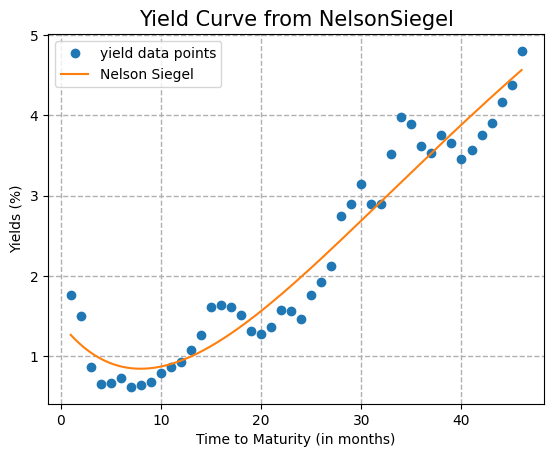

In [89]:
plt.figure()
plt.title('Yield Curve from NelsonSiegel', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(cmt_data_10y['time to maturity'], cmt_data_10y['GS10'], 'o', label = 'yield data points')
plt.plot(curve_points, NS_yield(curve_points, optimum_beta), label="Nelson Siegel")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

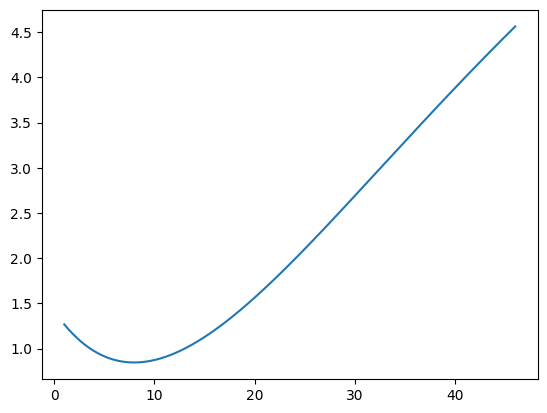

In [88]:
plt.plot(curve_points, NS_yield(curve_points, optimum_beta), label="Nelson Siegel")


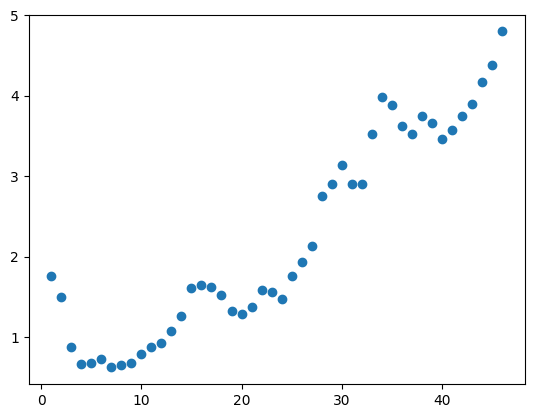

In [87]:
plt.plot(cmt_data_10y['time to maturity'], cmt_data_10y['GS10'], 'o', label = 'yield data points')
